In [9]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special

import numdifftools as ndt # to comput the Hessian matrix

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns


# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

rc={'lines.linewidth': 2, 
    'axes.labelsize' : 16, 
    'axes.titlesize' : 18,
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'xtick.labelsize' : 13,
    'ytick.labelsize' : 13,
    'grid.linestyle' : ':',
    'grid.color' : 'a6a6a6'}

sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette("deep", color_codes=True)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Bayesian Hierarchical model

In order to obtain the MWC parameters given the fold-change measurements Manuel took at MBL and a credible region on such parameters we will use a Bayesian hierarchical model to fit each individual data-set.

## The MWC theory of LacI IPTG induction
Our theoretical model dictates that the fold change in gene expression is given by
\begin{equation}
    fc = \frac{1}{1 + \frac{2R p_{act}(C)}{N_{NS}} \left( 1 + e^{-\beta \Delta \epsilon_{ai}} \right)  e^{-\beta \Delta \epsilon_r}},
\end{equation}
where $p_{act}(C)$ is given by
\begin{equation}
    p_{act}(C) = \frac{\left( 1 + C e^{\epsilon_A}\right)^2}{\left( 1 + C e^{\epsilon_A}\right)^2 + e^{-\beta \epsilon_{ai}} \left( 1 + C e^{\epsilon_I}\right)^2}.
\end{equation}

We define $\epsilon_A = -\ln K_A$ and $\epsilon_I = -\ln K_I$ for convenience. 

## Setting up the hierarchical model
Recalling that our objective is to infer the values of the dissociation constants $\mathbf{K} = (K_A, K_I)$ in the MWC model, let's think about the data that we have.

Our data consists of fold-change measurements done with different operators, different repressor copy numbers and different IPTG concentrations. On top of that we have multiple *biological replicas* performed in different days.

On the one hand, to find *the most representative parameters* for all the data we could simply **pool the data all together** and perform a global fit. But that simple act of pooling together the data implies strong assumptions. It assumes that the slight experimental/biological/paranormal differences are irrelevant and all the data was generated equally.

On the other hand we could take the other extreme point of view in which **each data-set is completely independent of the rest**. Fit a single parameter for each strain on each different day. But yet again this strategy implies different assumptions with their own caveats because if we believe in the theory the parameters should be in principle the same for all the strains and the biological replicas should be not very different from each other.

A *Bayesian hierarchical model* represents arguably the best of both worlds. In a hierarchical model each data set $d_i$ is assumed to have its own set of parameters $\mathbf{K}_i$ drawn from a distribution $P(\mathbf{K}_i \mid \mathbf{Q})$, where $\mathbf{Q} = (Q_A, Q_I)$ are the so-called *hyper-parameters*. One can think of the hyper-parameters as the most probable global parameter. On each experiment a set of parameters $\mathbf{K}$ is chosen from a distribution centered at these hyper-parameters.

I think (and that is part of the modeling decisions we need to make as scientists) that the most natural way of grouping the data is by single strain, single day with all IPTG concentrations. In other words we define as a "data set" the set of fold-changes measured for a single strain on a specific day. If we assume that the day-to-day variability and strian-to-strain variability gives small differences on th eparameters $\mathbf{K}$, we can model this variability by saying that the parameters for each data set are drawn out of a probability distribution
\begin{equation}
\mathbf{K} \sim P(\mathbf{K} \mid \mathbf{Q})
\end{equation}

Assuming this implies that we are set to find the set of parameters $\kappa = (\mathbf{K}_1, \mathbf{K}_2, \ldots)$ for each individual experiment, plus a hyper-parameter $\mathbf{Q} = (Q_A, Q_I)$.

By Bayes theorem this would imply that
\begin{equation}
P(\mathbf{Q}, \kappa \mid D, I) \propto P(D \mid \kappa, \mathbf{Q}, I) \cdot P(\mathbf{Q}, \kappa \mid I)
\end{equation}.

A single data set $d_i \in D$ does not depend directly on the hyperparameters $\mathbf{Q}$, but only on th sample parameters $\mathbf{K}_i$. This implies that
\begin{equation}
P(D \mid \kappa, \mathbf{Q}, I) = \prod_{i = 1}^n P(d_i \mid \mathbf{K}_i, I),
\end{equation}
where $n = \lvert D \rvert$ is the number of independent data sets.

The prior $P(\mathbf{Q}, \kappa \mid I)$ can be split into two terms using the definition of conditional probability
\begin{equation}
P(\mathbf{Q}, \kappa \mid I) = P(\kappa \mid \mathbf{Q}, I) \cdot P(\mathbf{Q} \mid I).
\end{equation}

Putting these terms together gives the posterior we would like to compute
\begin{equation}
P(\mathbf{Q}, \kappa \mid D, I) \propto \prod_{i = 1}^n P(d_i \mid \mathbf{K}_i, I) \cdot P(\kappa \mid \mathbf{Q}, I) \cdot P(\mathbf{Q} \mid I).
\end{equation}

This posterior is in fat our **full hierarchical model**.

## Defining each of the terms

### The likelihood
For a single data set $d_i$ we have the following dpendent and independent variables:

**independent variables**
\begin{equation}
\left\{ R^{(i)}, \Delta\epsilon_r^{(i)}, \left[ C_1, C_2, \ldots, C_l \right] \right\},
\end{equation}
where $R_i$ is the number of repressors, $\Delta \epsilon_r$ is the binding energy and $C_i$ are the $l$ IPTG concentrations measured experimentally.

**dependent variables**
\begin{equation}
\left\{ \left[ fc_1, fc_2, \ldots, fc_l \right] \right\},
\end{equation}
the full set of fold-changes as measured with the flow cytometer.

If as before we were to assume the errors $(fc_{exp} - fc_{theory})$ are normally distributed I can think of 3 forms to handle the errors:
1. Global constant error $\sigma$ independent of IPTG concentration and strain
2. IPTG dependent error where we would have a set $\mathbf{\sigma} = (\sigma_1, \ldots, \sigma_l)$ for each of the IPTG concentrations used in the experiment.
3. IPTG and strain dependent error where we would have an error associated with each concentration of IPTG and with each strain (meaning each unique repressor copy number and binding energy)
\begin{bmatrix}
    \sigma_{11} & \sigma_{12} & \sigma_{13} & \dots  & \sigma_{1l} \\
    \sigma_{21} & \sigma_{22} & \sigma_{23} & \dots  & \sigma_{2l} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    \sigma_{m1} & \sigma_{m2} & \sigma_{m3} & \dots  & \sigma_{ml}
\end{bmatrix}
where $m$ is the number of independent strains.

Let's first implement the simplest approach. We will assume we have a constant error over all concentrations and all strains. This means that we can write
\begin{equation}
P(d_i \mid \mathbf{K}_i, \sigma, I) = \left( 2 \pi \sigma^2 \right)^{-l / 2} \prod_{j = 1}^l \exp \left\{ - \frac{\left( fc_{exp}^{(ij)} -  fc_{thry}^{(ij)} \right)^2}{2 \sigma^2} \right\},
\end{equation}
where again $l$ is the number of IPTG concentrations, the superscript $(ij)$ indicates the $i$th data set and the $j$th IPTG concentration respectively and the $fc_{thry}^{(ij)} = fc\left(\epsilon_A^{(i)}, \epsilon_I^{(i)}, R^{(i)}, \Delta\epsilon_r^{(i)}, C^{(j)} \right)$ is the theoretical fold change given the set of indpedendent parameters.

### The probability $P(\mathbf{K} \mid \mathbf{Q}, I)$
For the probability $P(\mathbf{K} \mid \mathbf{Q}, I)$ we will assume a simple bivariate Gaussian centered at $\mathbf{Q}$, the hyper-parameter.
Again here we face a new modeling decision with respect to the error. From the analytical approach we saw that the parameters $\epsilon_A$ and $\epsilon_I$ are not independent. Therefore the bivariate Gaussian should include a covariance term $\sigma_{AI} = cov\left[ \epsilon_A, \epsilon_I \right] \neq 0$.
We will choose to include this term, therefore we will have
\begin{equation}
P(\mathbf{K}_i \mid \mathbf{Q}, \mathbf{\Sigma}, I) = \frac{1}{\sqrt{(2\pi)^2 \lvert \mathbf{\Sigma} \rvert}} \exp \left\{ -\frac{1}{2} (\mathbf{K}_i - \mathbf{Q})^T \mathbf{\Sigma}^{-1} (\mathbf{K}_i - \mathbf{Q}) \right\},
\end{equation}
where $\mathbf{\Sigma}$ is the covariance matrix
\begin{equation}
\mathbf{\Sigma} = \left[ \begin{array}{cc} \sigma_{A} & \sigma_{AI} \\ \sigma_{AI} & \sigma_{I} \end{array} \right],
\end{equation}
$\sigma_A$, and $\sigma_I$ are the standard deviations associated with the Gaussian distribution from which each data set samples their paramteres $\mathbf{K}_i $.

So the full set of parameters, assuming each data set is independent would have a distribution
\begin{align}
P(\kappa \mid \mathbf{Q}, I) &= \prod_{i=1}^n P(\mathbf{K}_i \mid \mathbf{Q}, I)
&= (2\pi \lvert \Sigma \rvert)^{-\frac{n}{2}} \prod_{i=1}^n \exp \left\{ -\frac{1}{2} (\mathbf{K}_i - \mathbf{Q})^T \mathbf{\Sigma}^{-1} (\mathbf{K}_i - \mathbf{Q}) \right\}
\end{align}

### The prior

We have come a long way from the original prior $P(\mathbf{Q} \mid I)$. We now have significantly many more parameters to fit for.
For simplicity we will assume that all the priors are indpendent, and given the nature of the variables we will assign to all of them a Jeffreys prior. Listing the parameters we have
\begin{equation}
P(\mathbf{Q}, \kappa, \sigma_{AI}) \propto \prod_{i=1}^n \left[ \frac{1}{\epsilon_A^{(i)}} \cdot \frac{1}{\epsilon_I^{(i)}} \right] \cdot \frac{1}{\sigma} \cdot \frac{1}{\sigma_A} \cdot \frac{1}{\sigma_I} \cdot \frac{1}{\sigma_{AI}}. 
\end{equation}

Time to put everything together!

The full posterior looks like
\begin{equation}
P(\mathbf{Q}, \kappa, \sigma, \mathbf{\Sigma} \mid D, I) \propto \prod_{i=1}^n \frac{1}{\sigma^l} \exp \left\{ - \frac{\sum_{j=1}^l \left( fc_{exp}^{(ij)} -  fc_{thry}^{(ij)} \right)^2}{2 \sigma^2} \right\} \cdot \prod_{i=1}^n \frac{1}{\sqrt{\lvert \mathbf{\Sigma} \rvert}} \exp \left\{ -\frac{1}{2} (\mathbf{K}_i - \mathbf{Q})^T \mathbf{\Sigma}^{-1} (\mathbf{K}_i - \mathbf{Q}) \right\} \cdot \prod_{i=1}^n \left[ \frac{1}{\epsilon_A^{(i)}} \cdot \frac{1}{\epsilon_I^{(i)}} \right] \cdot \frac{1}{\epsilon_A} \cdot \frac{1}{\epsilon_I} \cdot \frac{1}{\sigma} \cdot \frac{1}{\sigma_A^*} \cdot \frac{1}{\sigma_I^*} \cdot \frac{1}{\sigma_{AI}},
\end{equation}
where $ \mathbf{Q} = (\epsilon_A^*,\epsilon_I^*)$

Taking the log of this expression we get
\begin{equation}
\ln P(\mathbf{Q}, \kappa, \sigma, \mathbf{\Sigma} \mid D, I) \propto - (l\cdot n + 1) \ln \sigma - \frac{1}{2 \sigma} \sum_{i=1}^n \sum_{j=1}^l\left( fc_{exp}^{(ij)} -  fc_{thry}^{(ij)}\right)^2 - \frac{n}{2} \lvert \mathbf{\Sigma} \rvert - \frac{1}{2} \sum_{i=1}^n (\mathbf{K}_i - \mathbf{Q})^T \mathbf{\Sigma}^{-1} (\mathbf{K}_i - \mathbf{Q}) - \sum_{i=1}^n \left( \ln \epsilon_A^{(i)} + \ln \epsilon_I^{(i)} \right) - \ln \epsilon_A^* - \ln \epsilon_I^* - \ln \sigma_A - \ln \sigma_I - \ln \sigma_{AI}.
\end{equation}

Let's code up the functions to compute the theoretical fold-change

In [2]:
# define a funciton to compute the fold change as a funciton of IPTG
def pact(IPTG, ea, ei, epsilon=4.5):
    '''
    Returns the probability of a repressor being active as described by the MWC
    model.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    ea, ei : float.
        minus log of the dissociation constants of the active and the inactive 
        states respectively
    epsilon : float.
        energy difference between the active and the inactive state
    Returns
    -------
    pact : float.
        probability of a repressor of being in the active state. Active state is
        defined as the state that can bind to the DNA.
    '''
    pact = (1 + IPTG * np.exp(ea))**2 / \
    ((1 + IPTG * np.exp(ea))**2 + np.exp(-epsilon) * (1 + IPTG * np.exp(ei))**2)
    return pact

def fold_change(IPTG, ea, ei, epsilon, R, epsilon_r):
    '''
    Returns the gene expression fold change according to the thermodynamic model
    with the extension that takes into account the effect of the inducer.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    ea, ei : float.
        minus log of the dissociation constants of the active and the inactive 
        states respectively
    epsilon : float.
        energy difference between the active and the inactive state
    R : array-like.
        repressor copy number for each of the strains. The length of this array
        should be equal to the IPTG array. If only one value of the repressor is
        given it is asssume that all the data points should be evaluated with
        the same repressor copy number
    epsilon_r : array-like
        repressor binding energy. The length of this array
        should be equal to the IPTG array. If only one value of the binding
        energy is given it is asssume that all the data points 
        should be evaluated with the same repressor copy number
        
    Returns
    -------
    fold-change : float.
        gene expression fold change as dictated by the thermodynamic model.
   '''
    return 1 / (1 + 2 * R / 5E6 * pact(IPTG, ea, ei, epsilon) * \
            (1 + np.exp(-epsilon)) * np.exp(-epsilon_r))

Now let's code each of the terms involved in the $\log$ posterior

In [ ]:
def log_post(param, indep_var, dep_var):
    '''
    Computes the log posterior for a single set of parameters.
    Parameters
    ----------
    param : list.
        List containing all the parameters, i.e. dimensions on which the walkers
        will walk through
        param[0] : n x 2 array, where n = number of independent data sets.
            first column = epsilon_A values for each data set
            second column = epsilon_I values for each data set
        param[1] : array-like.
            2 x 1 array with epsilon_A^* and epsilon_I^* the most probable
            values for the hyper parameters.
        param[2] : array-like.
            2 x 1 array with sigma_A and sigma_I the variance associated with
            the hyper parameters.
        param[3] : float.
            covariance between epsilon_A^* and epsilon_I^*.
        param[4] : float.
            global sigma associated with the Gaussian likelihood.
    indep_var : list.
        List containing all the INDEPENDENT variables. The list must have
        n elements, where n is the number of independent data sets. Each element
        in the list must be a L x 3 array, where L is the number of IPTG 
        concentrations
            1st column : IPTG concentrations
            2nd column : repressor copy number
            3rd column : repressor binding energy
    dep_var : list.
        List containing all the DEPENDENT variables. The list must have
        n elements, where n is the number of independent data sets. Each element
        in the list must be an array with L elements, where L is the number
        of IPTG concentrations
        
    Returns
    -------
    log_post : float.
        the log posterior probability
    '''
    # unpack parameters
    kappa, Q_hyper, sigma_hyper, cov_hyper, sigma = param[0], param[1], \
                                                    param[2], param[3], sigma[4]
    
    # determine the number of experiments
    n = len(kappa)
    
    # compute the theoretical fold change for each data set
    fc_thry = list()
    for i, data_set in enumerate(indep_var):
        # unpack independent variables
        IPTG, R, epsilon_r = data_set[:, 0], data_set[:, 1], data_set[:, 2]
        # unpack the parameters epsilon_Ai and epsilon_Ii for this data set
        ea, ei = kappa[i, :]
        # compute the theoretical fold-change
        fc_theory.append(fold_change(IPTG, ea, ei, 4.5, R, epsilon_r))

# Testing the functions with only 1 strain and one operator 

Now it is time to test this! But first let's read the data

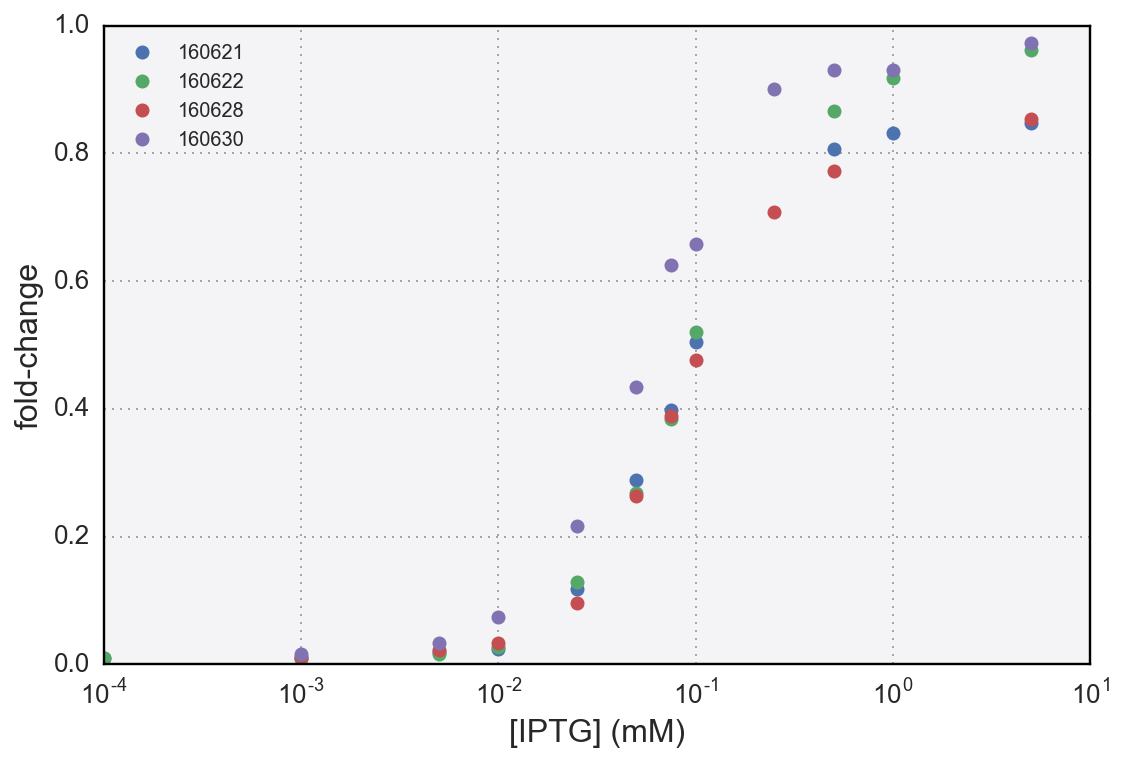

In [4]:
#Load the data. 
data = pd.read_csv('../../data/mbl_2016/MBL_fc_data.csv')

# Let's first try to do the regression using only one RBS and one operator
rbs = data[(data.strain=='1027') & (data.epsilon_r==-13.9)]

plt.figure()
for date in rbs.date.unique():
    plt.plot(rbs[rbs.date==date].IPTG, rbs[rbs.date==date].fold_change, 'o',
            label=str(date))
plt.xscale('log')
plt.xlabel('[IPTG] (mM)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')
plt.tight_layout()